In [1]:
import pickle
import re

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import MultiPolygon, Polygon

In [2]:
sns.set_style("whitegrid")

In [3]:
def add_singular_form(names):
    return names + [name[:-1] for name in names if name.endswith("s")]

In [4]:
countries_iso_3 = {country.name: country.alpha_3 for country in list(pycountry.countries)}

national_forms = pd.read_csv("./data/countries_adjectivals_demonyms_wiki.csv")
national_forms = national_forms.applymap(lambda text: re.sub(r"(\(.*\))|(\[.*\])", "", text))  # get rid off wiki comments in brackets
national_forms = national_forms.loc[national_forms["country"].isin(countries_iso_3)] 
national_forms["iso_a3"] = national_forms["country"].apply(lambda country: countries_iso_3[country])

national_forms["adjectivals"] = national_forms["adjectivals"].apply(lambda text: text.lower().split("\r\n"))  # adjectivals to lists
national_forms["demonyms"] = national_forms["demonyms"].apply(lambda text: text.lower().split("\r\n"))  # demonyms to lists
national_forms["demonyms"] = national_forms["demonyms"].apply(add_singular_form)  # add singular forms based on plural
# national_forms["country"] = national_forms["country"].apply(lambda text: text.lower())

national_forms.head(10)

,country,adjectivals,demonyms,iso_a3
1,Afghanistan,[afghan],"[afghans, afghan]",AFG
3,Albania,[albanian],"[albanians, albanian]",ALB
4,Algeria,[algerian],"[algerians, algerian]",DZA
5,American Samoa,[american samoan],"[american samoans, american samoan]",ASM
6,Andorra,[andorran],"[andorrans, andorran]",AND
7,Angola,[angolan],"[angolans, angolan]",AGO
8,Anguilla,[anguillan],"[anguillans, anguillan]",AIA
9,Antarctica,[antarctic],"[antarctic residents, antarcticans, antarctic ...",ATA
10,Antigua and Barbuda,"[antiguan, barbudan]","[antiguans, barbudans, antiguan, barbudan]",ATG
11,Argentina,"[argentine, argentinian]","[argentines, argentinians, argentine, argentin...",ARG


In [5]:
def load_anthems_data(path="./data/data.pickle", 
                      punctuation_to_keep=",.:;?!'-", 
                      lyrics_lowercase=False, 
                      countries_lowercase=False, 
                      clean_countries=False, # remove additional text in parantheses (e.g years) 
                      keep_countries_without_lyrics=True,
                      keep_countries_with_invalid_iso2=False,
                      add_iso3_codes=True):
                        
    with open(path, "rb") as handle:
        data = pickle.load(handle)

    _df = pd.DataFrame.from_dict(data, orient="index", columns=["iso_2", "lyrics"])
    countries_iso_2 = [country.alpha_2 for country in list(pycountry.countries)]
    countries_iso_3 = [country.alpha_3 for country in list(pycountry.countries)]

    if not keep_countries_with_invalid_iso2:
        df = _df.loc[_df["iso_2"].isin(countries_iso_2)].copy()  # Create a copy of the DataFrame slice
    else: df = _df.copy()

    if add_iso3_codes:
        if keep_countries_with_invalid_iso2:
            raise ValueError("Cannot add iso3 codes when `keep_countries_with_invalid_iso2` is set to `True`")
        df["iso_a3"] = np.array(countries_iso_3)[[countries_iso_2.index(i) for i in df["iso_2"].values]]
        df.loc["Kosovo", :] = _df.loc["Kosovo"].to_list() + ["-99"]
        df.loc["Somaliland", :] = _df.loc["Somaliland"].to_list() + ["SOL"]
        columns = ["iso_2", "iso_a3", "lyrics"]
    else: columns = ["iso_2", "lyrics"]

    punctuation_pattern = "[^\\w\\d" + "\\".join(list(punctuation_to_keep)) + "\\s]+" 
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r"[0-9][\.]?", "", text)) # remove numbers and numbers with dot
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r"chorus", "", text, flags=re.IGNORECASE)) # remove CHORUS strings
    df["lyrics"] = df["lyrics"].apply(lambda text: text.replace("\r", " ").replace("\n", " ")) # remove newline characters
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(r" {2,}", " ", text)) # remove double spaces
    df["lyrics"] = df["lyrics"].apply(lambda text: re.sub(punctuation_pattern, "", text)) # remove selected punctuation
    df["lyrics"] = df["lyrics"].apply(lambda text: text.strip()) # remove trailing spaces
    if lyrics_lowercase:
        df["lyrics"] = df["lyrics"].apply(lambda text: text.lower())
    if countries_lowercase:
        df.index = df.index.str.lower()
    if clean_countries: # remove additional text in parantheses (e.g years)
        df.index = df.index.map(lambda name: re.sub(r"(\(.*\))|(\[.*\])", '', name).strip())
    if not keep_countries_without_lyrics:
        df = df[df["lyrics"] != ""]

    return df[columns].sort_index(inplace=False)

In [6]:
df = load_anthems_data(
    punctuation_to_keep="'", 
    lyrics_lowercase=True, 
    countries_lowercase=True, 
    clean_countries=True,
    keep_countries_without_lyrics=True)
df

,iso_2,iso_a3,lyrics
504 gateway time-out,BH,BHR,
afghanistan,AF,AFG,this land is afghanistan it is pride of every ...
aland islands,AX,ALA,the land of thousand islands and skerries born...
albania,AL,ALB,around our flag we are united with one will an...
algeria,DZ,DZA,we swear by the lightning that destroys by the...
...,...,...,...
wallis and futuna,WF,WLF,
western sahara,EH,ESH,o sons of the sahara in the battlefield you ar...
yemen,YE,YEM,repeat oh world my song echo it over and over ...
zambia,ZM,ZMB,stand and sing of zambia proud and free land o...


In [7]:
national_forms = national_forms.loc[national_forms["iso_a3"].isin(df["iso_a3"])]
national_forms

,country,adjectivals,demonyms,iso_a3
1,Afghanistan,[afghan],"[afghans, afghan]",AFG
3,Albania,[albanian],"[albanians, albanian]",ALB
4,Algeria,[algerian],"[algerians, algerian]",DZA
5,American Samoa,[american samoan],"[american samoans, american samoan]",ASM
6,Andorra,[andorran],"[andorrans, andorran]",AND
...,...,...,...,...
255,Wallis and Futuna,"[wallis and futuna, wallisian, futunan]","[wallis and futuna islanders, wallisians, futu...",WLF
256,Western Sahara,"[sahrawi, saharawi, western saharan]","[sahrawis, saharawis, western saharans, sahraw...",ESH
257,Yemen,[yemeni],"[yemenis, yemeni]",YEM
258,Zambia,[zambian],"[zambians, zambian]",ZMB


In [8]:
forms_dict = {}

for idx, row in national_forms.iterrows():
    iso_code = countries_iso_3[row["country"]]
    forms_dict[row["country"]] = iso_code
    for adjectival in row["adjectivals"]:
        forms_dict[adjectival] = iso_code
    for demonym in row["demonyms"]:
        forms_dict[demonym] = iso_code
    
forms_dict = {k.lower(): v for (k, v) in forms_dict.items()}

In [9]:
forms_dict

{'afghanistan': 'AFG',
 'afghan': 'AFG',
 'afghans': 'AFG',
 'albania': 'ALB',
 'albanian': 'ALB',
 'albanians': 'ALB',
 'algeria': 'DZA',
 'algerian': 'DZA',
 'algerians': 'DZA',
 'american samoa': 'ASM',
 'american samoan': 'ASM',
 'american samoans': 'ASM',
 'andorra': 'AND',
 'andorran': 'AND',
 'andorrans': 'AND',
 'angola': 'AGO',
 'angolan': 'AGO',
 'angolans': 'AGO',
 'anguilla': 'AIA',
 'anguillan': 'AIA',
 'anguillans': 'AIA',
 'antigua and barbuda': 'ATG',
 'antiguan': 'ATG',
 'barbudan': 'ATG',
 'antiguans': 'ATG',
 'barbudans': 'ATG',
 'argentina': 'ARG',
 'argentine': 'ARG',
 'argentinian': 'ARG',
 'argentines': 'ARG',
 'argentinians': 'ARG',
 'armenia': 'ARM',
 'armenian': 'ARM',
 'armenians': 'ARM',
 'aruba': 'ABW',
 'aruban': 'ABW',
 'arubans': 'ABW',
 'australia': 'AUS',
 'australian': 'AUS',
 'australians': 'AUS',
 'austria': 'AUT',
 'austrian': 'AUT',
 'austrians': 'AUT',
 'azerbaijan': 'AZE',
 'azerbaijani': 'AZE',
 'azeri': 'AZE',
 'azerbaijanis': 'AZE',
 'azeris'

In [10]:
all_demonyms = set(form for forms in national_forms["demonyms"].tolist() for form in forms)
all_adjectivals = set(form for forms in national_forms["adjectivals"].tolist() for form in forms)
all_countries = set(national_forms["country"])
all_forms = all_countries | all_demonyms | all_adjectivals
all_forms = {form.lower() for form in all_forms}

In [11]:
df["bag_of_words"] = df["lyrics"].apply(lambda text: set(text.split(" ")))
df["mentions"] = df["bag_of_words"].apply(lambda words: words & all_forms)
df["mentions"] = df["mentions"].apply(lambda mentions: list({forms_dict[mention] for mention in mentions}))
df

,iso_2,iso_a3,lyrics,bag_of_words,mentions
504 gateway time-out,BH,BHR,,{},[]
afghanistan,AF,AFG,this land is afghanistan it is pride of every ...,"{pashaye, as, like, afghanistan, braves, one, ...","[TJK, AFG, UZB]"
aland islands,AX,ALA,the land of thousand islands and skerries born...,"{days, it, loving, waves, land, skerries, over...","[SWE, POL]"
albania,AL,ALB,around our flag we are united with one will an...,"{, one, proclaiming, sacred, struggle, with, m...",[]
algeria,DZ,DZA,we swear by the lightning that destroys by the...,"{destroys, time, front, cry, it, fatherland, r...","[FRA, DZA]"
...,...,...,...,...,...
wallis and futuna,WF,WLF,,{},[]
western sahara,EH,ESH,o sons of the sahara in the battlefield you ar...,"{one, struggle, it, remove, idol, will, agains...",[]
yemen,YE,YEM,repeat oh world my song echo it over and over ...,"{mine, it, clothe, all, over, will, no, arab, ...",[YEM]
zambia,ZM,ZMB,stand and sing of zambia proud and free land o...,"{, motherland, one, as, like, by, africa, prai...",[ZMB]


In [12]:
import geopandas as gpd
world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world_all.merge(df, on="iso_a3")
world["mentions"] = world["mentions"].apply(lambda mentions: [m for m in mentions if m in world["iso_a3"].values])
world.head()

C:\Users\Manik\AppData\Local\Temp\ipykernel_1312\1573166685.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_all = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso_2,lyrics,bag_of_words,mentions
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJ,blessing grant oh god of nations on the isles ...,"{, as, happiness, hope, shores, glory, with, m...",[FJI]
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZ,god bless africa bless its leaders let wisdom ...,"{, africa, eternal, sons, shield, the, its, wi...",[]
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",EH,o sons of the sahara in the battlefield you ar...,"{one, struggle, it, remove, idol, will, agains...",[]
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CA,o canada our home and native land true patriot...,"{north, patriot, command, with, native, for, a...",[CAN]
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US,oh say can you see by the dawns early light wh...,"{gave, haughty, reflected, it, terror, desolat...",[]


In [13]:
def country_to_iso3(country):
    return world[world["country"] == country]["iso_a3"].values[0]

def iso3_to_country(iso3):
    return world[world["iso_a3"] == iso3]["name"].values[0]

In [14]:
edges = dict(zip(world["iso_a3"], world["mentions"]))
for key in edges:
    if key in edges[key]:
        edges[key].remove(key)

edges = dict((iso3_to_country(k), [iso3_to_country(v) for v in vs]) for k, vs in edges.items())
edges = dict((k, vs) for k, vs in edges.items() if vs)


In [15]:
edges

{'Papua New Guinea': ['Guinea'],
 'Peru': ['Spain'],
 'Honduras': ['India', 'France'],
 'Eq. Guinea': ['Guinea'],
 'Lebanon': ['Poland'],
 'Algeria': ['France'],
 'Afghanistan': ['Tajikistan', 'Uzbekistan'],
 'Poland': ['Italy', 'Sweden'],
 'Hungary': ['Mongolia', 'Turkey'],
 'Netherlands': ['Spain', 'Israel'],
 'Italy': ['Poland', 'Austria'],
 'Cyprus': ['Greece'],
 'S. Sudan': ['Sudan']}

## Remove mistakes and add aditional edges

In [16]:
edges.pop('Papua New Guinea')
edges.pop('Eq. Guinea')
edges.pop('Lebanon')
edges.pop('S. Sudan')
edges["Honduras"].remove('India')
edges["Uruguay"] = ["Israel"]

In [17]:
# get rid of French Guiana in order to properly calculate France's polygon centroid
tmp = [x.replace(')','') for x in str(world.loc[42,'geometry']).split('((')[1:]][1]
tmp2 = [x.split(' ') for x in tmp.split(', ')][:-1]
tmp3 = [(float(x[0]),float(x[1])) for x in tmp2]
France_mainland = Polygon(tmp3)
world.loc[world['name']=='France','geometry'] = France_mainland 

In [18]:
def custom_layout(G):
    nodes = G.nodes.keys()
    layout_dict = {}
    for node in nodes:
        geom_point = world[world["name"] == node]["geometry"].values[0].centroid
        x_coord = geom_point.xy[0][0]
        y_coord = geom_point.xy[1][0]
        layout_dict[node] = np.array([x_coord, y_coord])
    return layout_dict

In [19]:
G = nx.DiGraph()
G.add_edges_from([((node, nbr)) for node, nbrlist in edges.items() for nbr in nbrlist])
pos = nx.circular_layout(G)
layout = custom_layout(G)
for node in layout:
    pos[node] = layout[node]

In [20]:
plt.rcParams["font.family"] = "Rozha One"

In [22]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_close("svg")

NameError: name 'set_matplotlib_close' is not defined

C:\Users\Manik\AppData\Local\Temp\ipykernel_1312\1031327409.py:32: UserWarning: Glyph 10145 (\N{BLACK RIGHTWARDS ARROW}) missing from current font.
  plt.savefig("figures/direct_mentions.svg", bbox_inches="tight", transparent=True)
c:\Users\Manik\miniconda3\envs\unstructured\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10145 (\N{BLACK RIGHTWARDS ARROW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


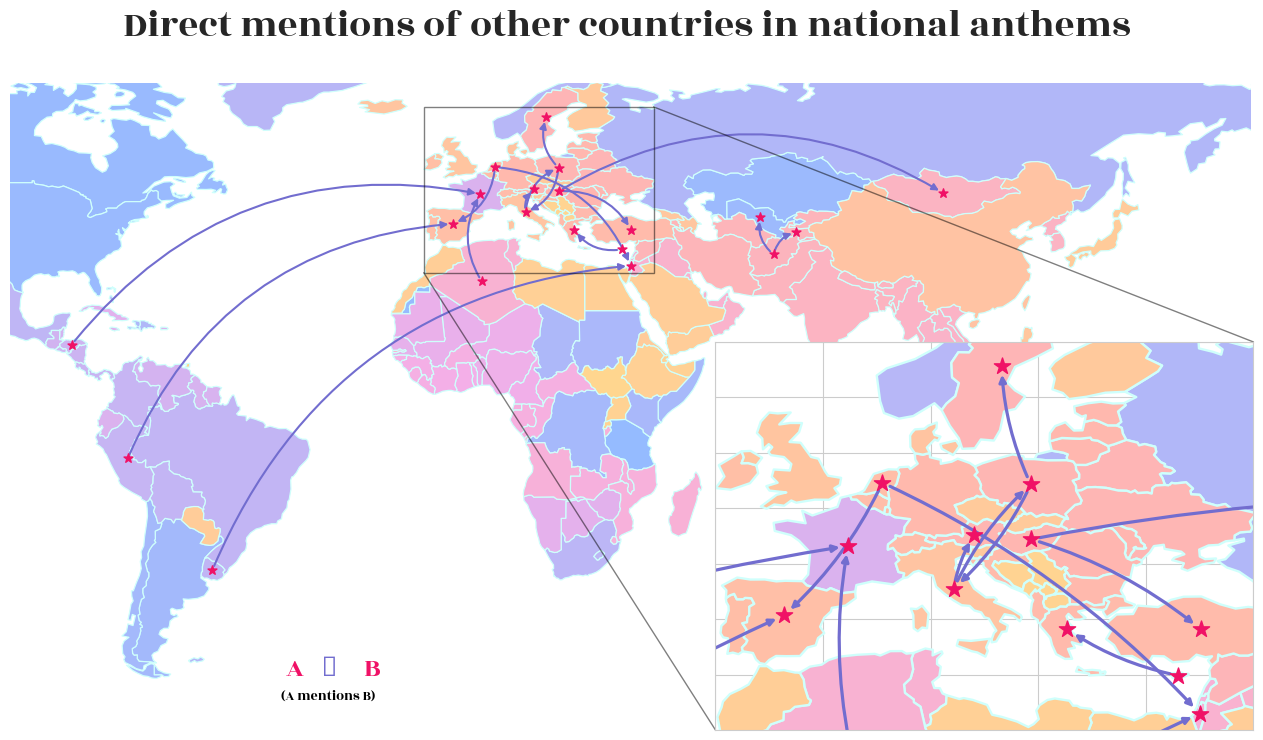

In [23]:
edge_color = "#cffffc"
arrow_color = "#726dcf"
node_color = "#f01166"
colors3 = ["#94bbff", "#f4afe8", "#ffb6b0", "#ffd68f"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors3)

fig, ax = plt.subplots(figsize=(20, 8))
world.plot(ax=ax, cmap=cmap1, edgecolor=edge_color, linewidth=0.9)
nx.draw(G, pos, node_size=45, node_shape="*", node_color=node_color, edge_color=arrow_color, width=1.5, connectionstyle="arc3, rad=-0.3")
ax.set_xlim(-100, 170)
ax.set_ylim(-60, 70)

axin = ax.inset_axes([0.47, -0.05, 0.63, 0.63])
world.plot(ax=axin, cmap=cmap1, edgecolor=edge_color, linewidth=1.7)
nx.draw(G, pos, label="1", ax=axin, node_size=150, node_shape="*", node_color=node_color, edge_color=arrow_color, width=2.3, connectionstyle="arc3, rad=-0.1")
axin.set_xlim(-10, 40)
axin.set_ylim(30, 65)
ax.indicate_inset_zoom(axin, edgecolor="black")
axin.axis("on")

legend_x = -45
legend_y = -65
ax.annotate('A', xy=(0, 0), xytext=(legend_x+5, legend_y+10), color=node_color, size=20, weight="bold")
ax.annotate(r' ➡', xy=(0, 0), xytext=(legend_x+11, legend_y+10), color=arrow_color, size=20)
ax.annotate('B', xy=(0, 0), xytext=(legend_x + 22, legend_y+10), color=node_color, size=20, weight="bold")
ax.annotate('(A mentions B)', xy=(0, 0), xytext=(legend_x+4, legend_y+5), color="black", size=10)

title_font = {"family": "Rozha One", "size": 28, "weight": "bold"}

plt.title("Direct mentions of other countries in national anthems \n", fontdict=title_font)

plt.savefig("figures/direct_mentions.svg", bbox_inches="tight", transparent=True)

plt.show()


# Wordclouds by continent

In [23]:
from wordcloud import WordCloud, STOPWORDS
from matplotlib import cm
from PIL import Image

stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("s")

In [37]:
world["continent"].unique()

array(['Oceania', 'Africa', 'North America', 'Asia', 'South America',
       'Europe'], dtype=object)

In [82]:
lyrics_africa = world[world["continent"] == "Africa"]["lyrics"].str.cat(sep=", ")
lyrics_europe = world[world["continent"] == "Europe"]["lyrics"].str.cat(sep=", ")
lyrics_namerica = world[world["continent"] == "North America"]["lyrics"].str.cat(sep=", ")
lyrics_samerica = world[world["continent"] == "South America"]["lyrics"].str.cat(sep=", ")
lyrics_oceania = world[world["continent"] == "Oceania"]["lyrics"].str.cat(sep=", ")
lyrics_asia = world[world["continent"] == "Asia"]["lyrics"].str.cat(sep=", ")

mask_africa = np.array(Image.open('figures/wordcloud_masks/africa_m.jpg'))
mask_oceania = np.array(Image.open('figures/wordcloud_masks/oceania_m.jpg'))
mask_asia = np.array(Image.open('figures/wordcloud_masks/asia_m.jpg'))
mask_europe = np.array(Image.open('figures/wordcloud_masks/europe_m.jpg'))
mask_namerica = np.array(Image.open('figures/wordcloud_masks/north_america_m.jpg'))
mask_samerica = np.array(Image.open('figures/wordcloud_masks/south_america_m.jpg'))

cmap_africa = LinearSegmentedColormap.from_list("mycmap", ("#007031", "#ffb326"))
cmap_europe = LinearSegmentedColormap.from_list("mycmap", ("#8f26ff", "#0db558"))
cmap_namerica = LinearSegmentedColormap.from_list("mycmap", ("#ff7d26", "#ffb326"))
cmap_samerica = LinearSegmentedColormap.from_list("mycmap", ("#825123", "#29d63a"))
cmap_oceania = LinearSegmentedColormap.from_list("mycmap", ("#4326ff", "#2696ff"))
cmap_asia = LinearSegmentedColormap.from_list("mycmap", ("#de002c", "#de00cf"))

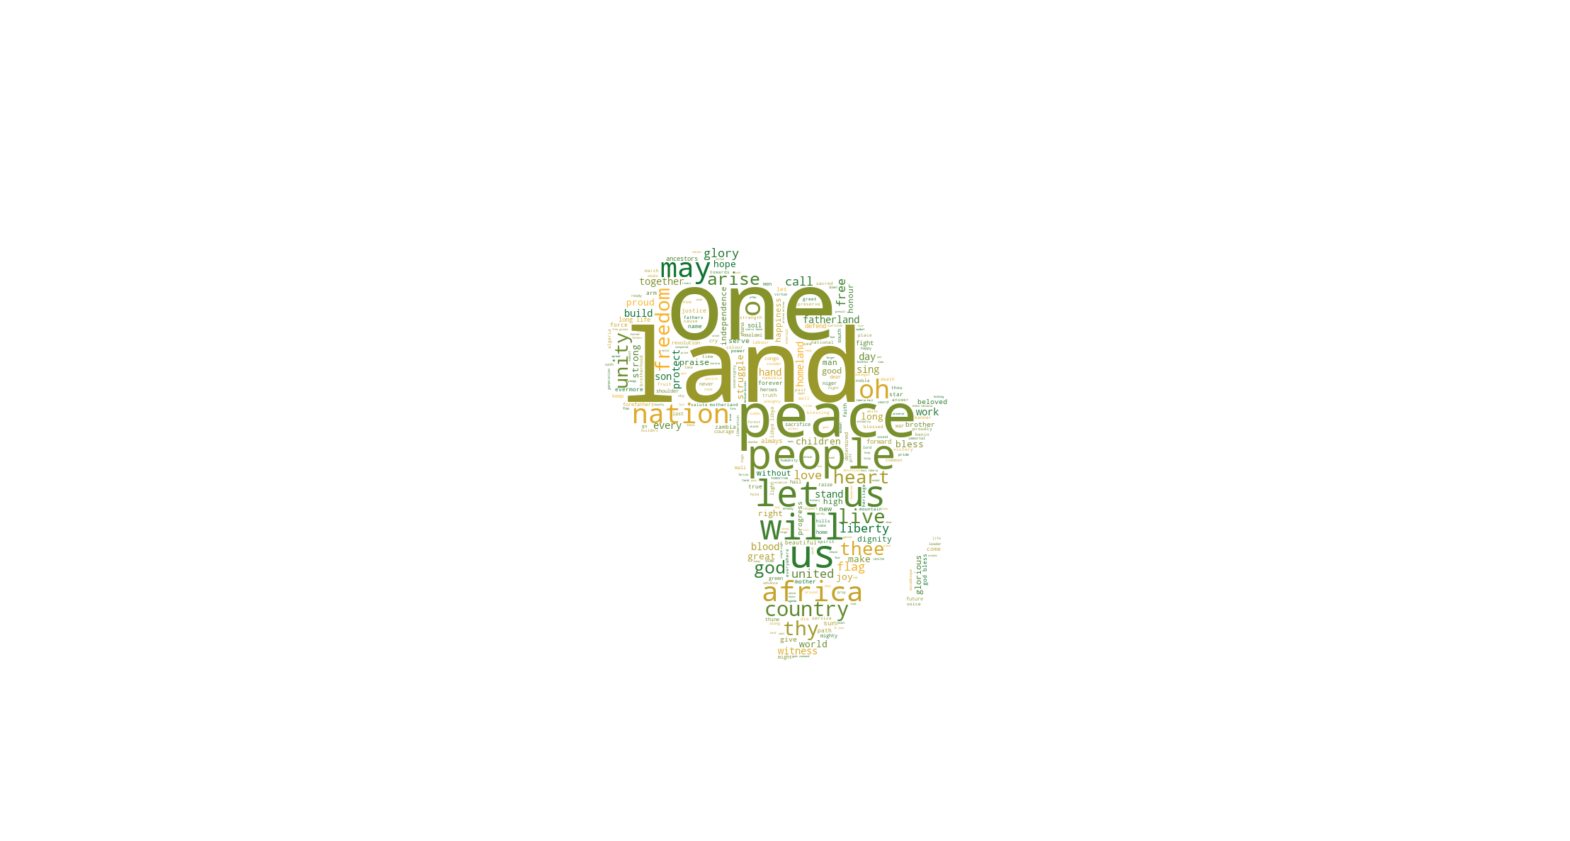

In [83]:
wordcloud = WordCloud(stopwords=stopwords, max_words=2000, mask=mask_africa, width=1000, height=1000, background_color="white", colormap=cmap_africa).generate(lyrics_africa)

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

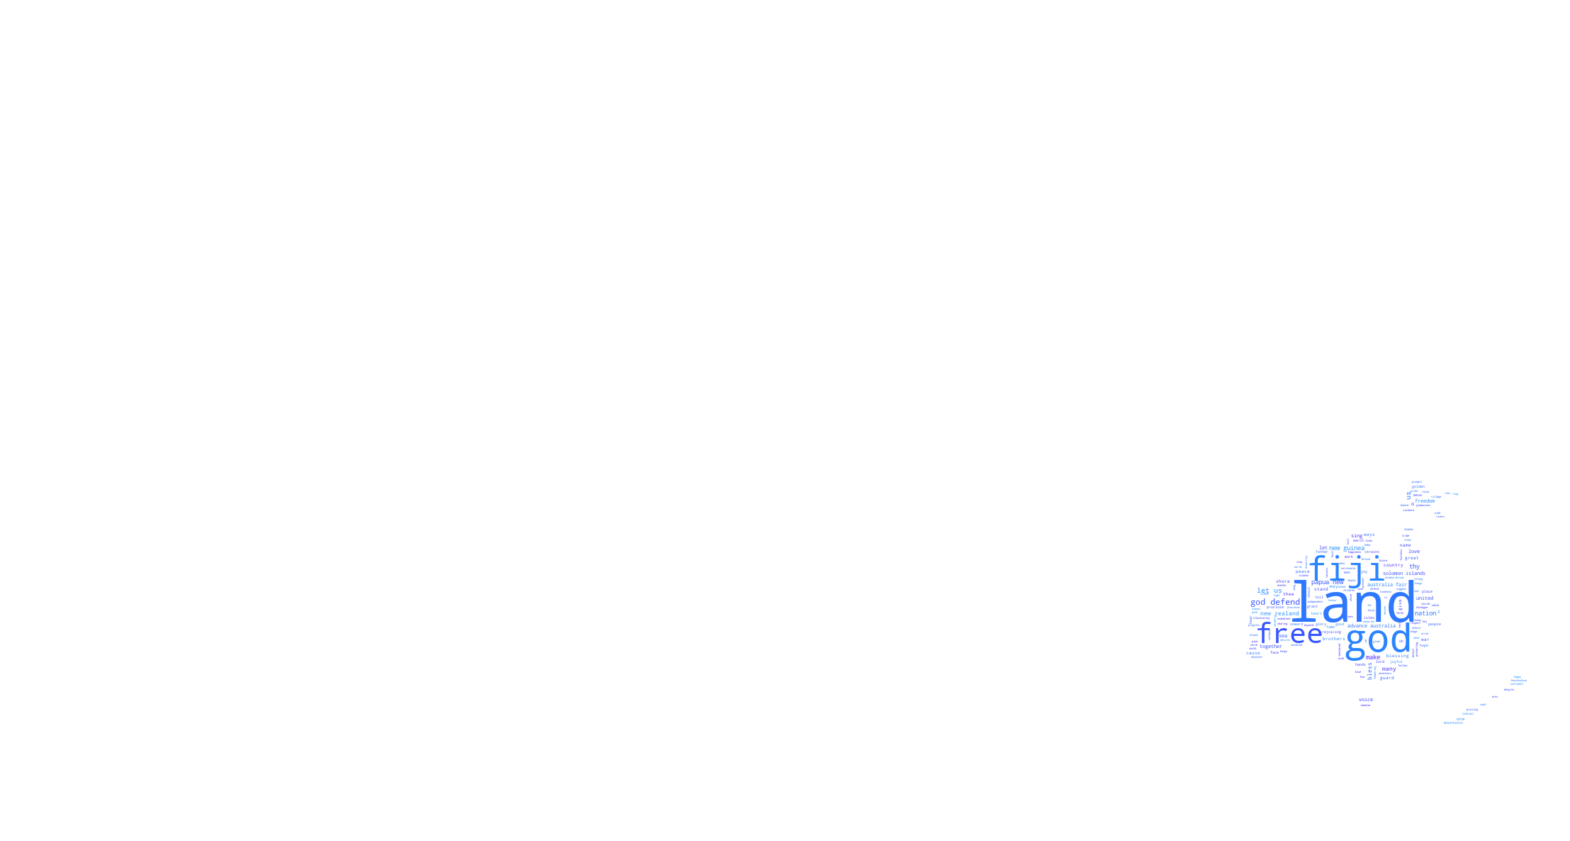

In [84]:
wordcloud = WordCloud(stopwords=stopwords, max_words=2000, mask=mask_oceania, width=1000, height=1000, background_color="white", colormap=cmap_oceania).generate(lyrics_oceania)

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

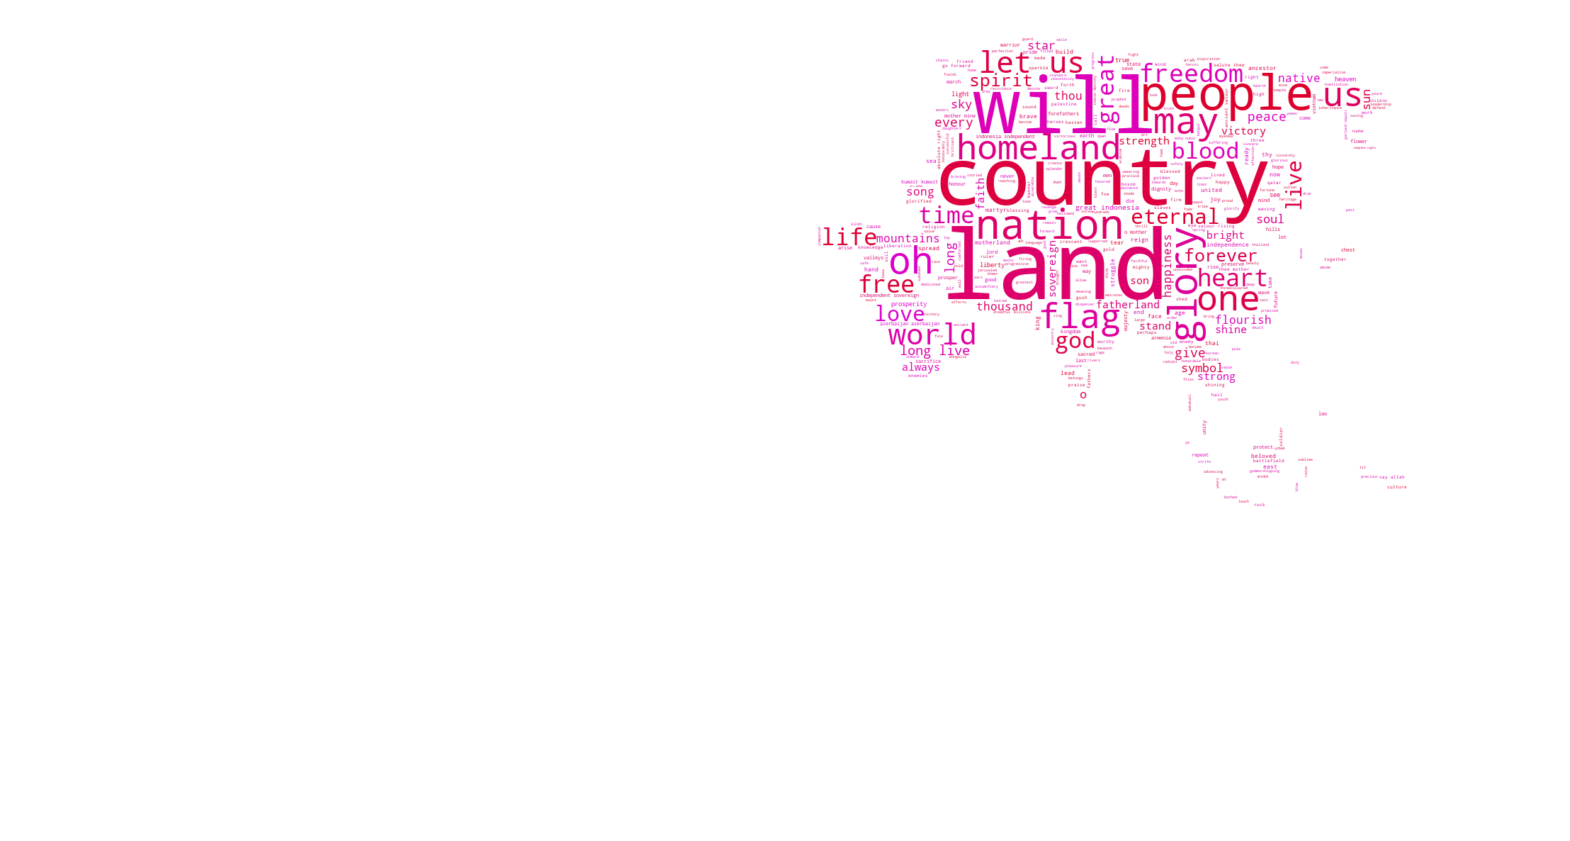

In [85]:
wordcloud = WordCloud(stopwords=stopwords, max_words=2000, mask=mask_asia, width=1000, height=1000, background_color="white", colormap=cmap_asia).generate(lyrics_asia)

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

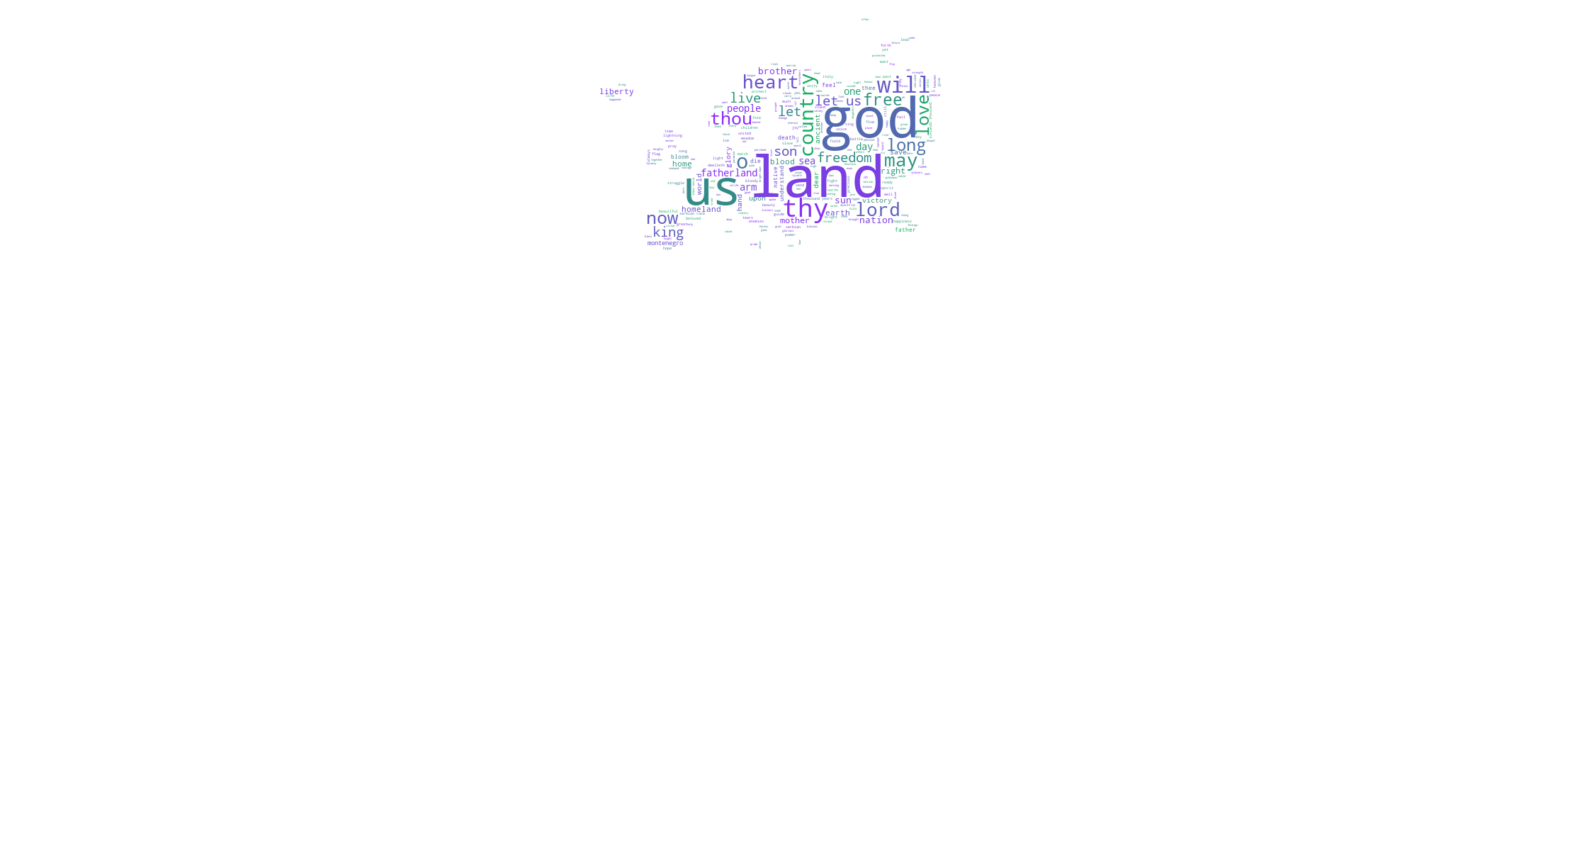

In [86]:
wordcloud = WordCloud(stopwords=stopwords, max_words=2000, mask=mask_europe, width=1000, height=1000, background_color="white", colormap=cmap_europe).generate(lyrics_europe)

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

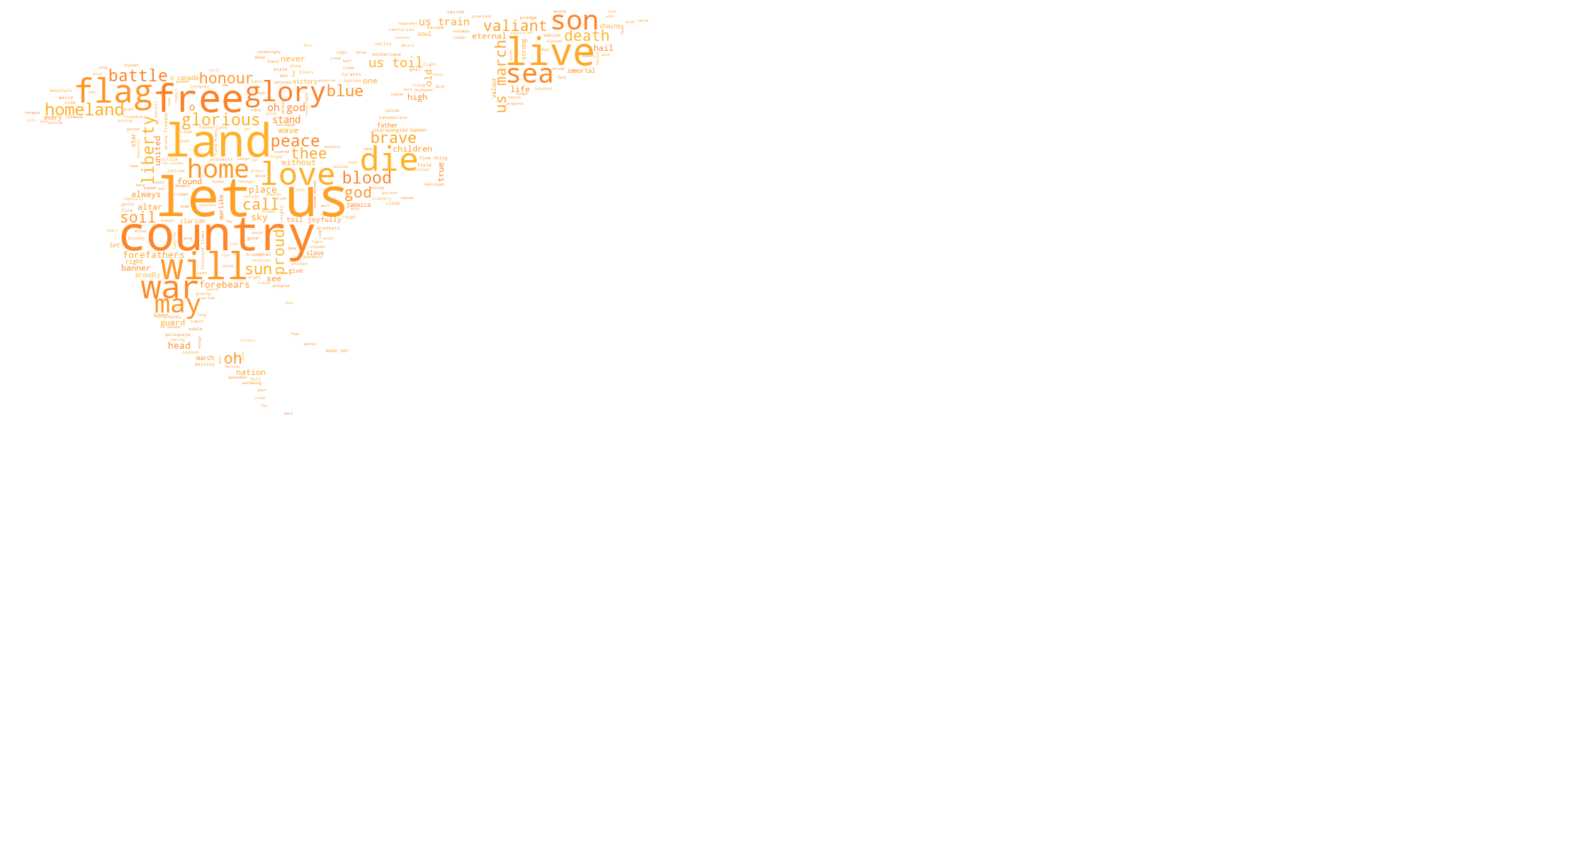

In [87]:
wordcloud = WordCloud(stopwords=stopwords, max_words=2000, mask=mask_namerica, width=1000, height=1000, background_color="white", colormap=cmap_namerica).generate(lyrics_namerica)

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

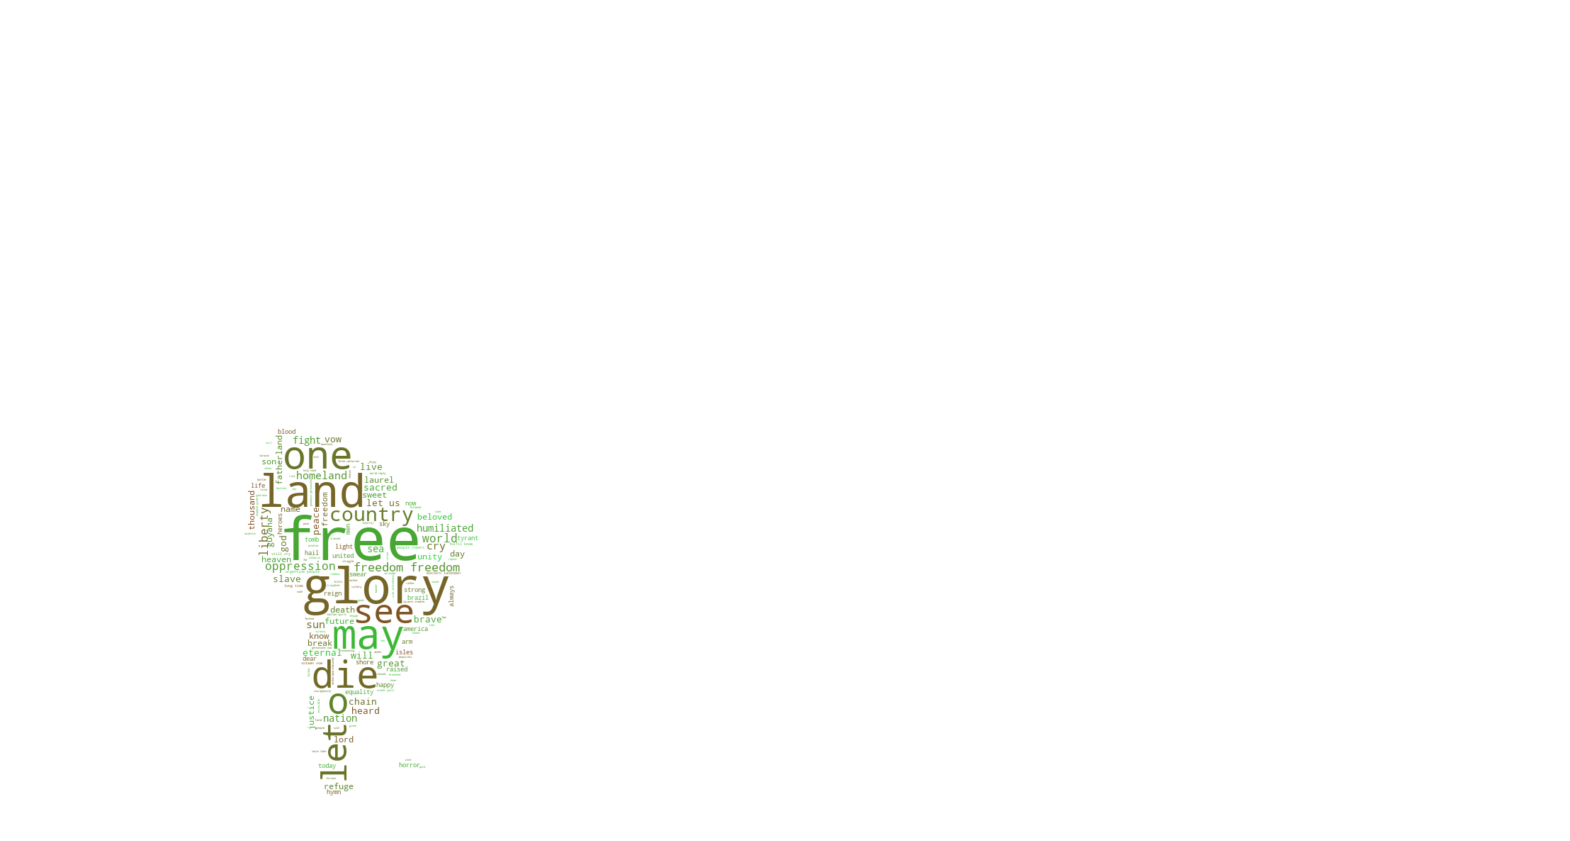

In [88]:
wordcloud = WordCloud(stopwords=stopwords, max_words=2000, mask=mask_samerica, width=1000, height=1000, background_color="white", colormap=cmap_samerica).generate(lyrics_samerica)

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");